## Part 1: Dataset Simulation

In [10]:
# Library imports

import pandas as pd
import numpy as np
from datetime import datetime
import random
from google import genai
from google.genai import types
from collections import Counter
import os
import math
import time
import json

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

from dotenv import load_dotenv
load_dotenv()

output_filename = 'data/sim_customers_seed_42.csv'

In [5]:
# Helper: robustly convert various SDK response types to plain string for JSON parsing

def _extract_text(obj):
    """Recursively extract text from SDK response objects.
    Handles str/bytes, lists, objects with .text/.content/.output, pydantic models, response.candidates, and fallbacks to str().
    """
    if obj is None:
        return ""
    if isinstance(obj, str):
        return obj
    if isinstance(obj, (bytes, bytearray)):
        try:
            return obj.decode('utf-8')
        except Exception:
            return str(obj)
    # If object has 'parts' (GenAI SDK), extract part contents
    try:
        if hasattr(obj, 'parts') and obj.parts:
            # join all part contents
            return "\n".join(_extract_text(p) for p in obj.parts)
    except Exception:
        pass
    # If it's a list or tuple, join items
    if isinstance(obj, (list, tuple)):
        return "\n".join(_extract_text(x) for x in obj)
    # Common nested attributes
    for attr in ("text", "content", "output", "value", "data"):
        try:
            val = getattr(obj, attr, None)
        except Exception:
            val = None
        if val:
            return _extract_text(val)
    # If object is a dict-like
    try:
        if isinstance(obj, dict):
            return json.dumps(obj)
    except Exception:
        pass
    # Try pydantic/BaseModel .json() or .dict()
    try:
        if hasattr(obj, 'json') and callable(obj.json):
            return obj.json()
    except Exception:
        pass
    try:
        if hasattr(obj, 'dict') and callable(obj.dict):
            return json.dumps(obj.dict())
    except Exception:
        pass
    # Fallback to string
    return str(obj)


In [26]:
# Methods used in the simulation

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

TRANSACTION_CATEGORIES = ["groceries", "utilities", "entertainment", "dining", "transport", "healthcare", "shopping", "education", "rent", "salary", "transfer"]

def generate_feedback_gemini_batch(summaries, n_requests=10, model="gemini-2.5-flash", max_retries=3, retry_delay=5, batch_delay_seconds=4):
    """Send summaries to Gemini in n_requests batches and return feedback map.

    This function WILL raise if the GenAI SDK is missing, the GOOGLE_API_KEY env var
    is not set, or if Gemini fails to produce valid JSON for any batch after retries.

    summaries: list of dicts, each must include 'customer_id' and other summary fields.
    n_requests: desired number of Gemini calls (e.g., 10 to respect quotas).
    batch_delay_seconds: seconds to sleep between successful batch calls to avoid bursts.
    Returns: {customer_id: feedback_text}
    """
    # Strict preconditions for Gemini-only mode
    if 'genai' not in globals() or genai is None or 'types' not in globals() or types is None:
        raise RuntimeError("Google GenAI SDK not available. Install the official SDK before enabling Gemini.")

    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        raise ValueError("GOOGLE_API_KEY not found in environment variables; required for Gemini mode.")

    client = genai.Client(api_key=GOOGLE_API_KEY)

    feedback_map = {}
    total = len(summaries)
    if total == 0:
        return feedback_map

    batch_size = max(1, math.ceil(total / n_requests))

    for i in range(0, total, batch_size):
        batch = summaries[i:i+batch_size]
        # Build strict JSON-response prompt
        items_text = []
        for s in batch:
            items_text.append(f"ID: {s['customer_id']} | credits: {s['total_credits']:.2f} | debits: {s['total_debits']:.2f} | end_balance: {s['ending_balance']:.2f} | top: {s['top_category']}")
        prompt_body = "\n".join(items_text)
        prompt = (
            "You are given multiple short customer monthly summaries (one per line in the format 'ID: <id> | ...').\n"
            "For each summary, produce a JSON array of objects with fields {\"customer_id\": <id>, \"feedback\": <short advice sentence>} and NOTHING ELSE.\n"
            "Keep each feedback within 10 words and make them varied and realistic. Example: \"I plan to increase my savings next month.\"\n"
            "Respond with valid JSON only (no extra commentary).\n\n"
            f"Summaries:\n{prompt_body}"
        )

        attempt = 0
        resp_text = None
        last_exception = None
        while attempt < max_retries:
            try:
                response = client.models.generate_content(
                    model=model,
                    contents=[prompt],
                    config=types.GenerateContentConfig(
                        system_instruction="You are generating short customer feedback notes for a synthetic banking dataset.",
                        thinking_config=types.ThinkingConfig(thinking_budget=-1)
                    )
                )
                # Extract returned text conservatively
                resp_text = _extract_text(response)
                if resp_text:
                    break
                else:
                    raise RuntimeError('Empty response from Gemini')
            except Exception as e:
                last_exception = e
                attempt += 1
                wait = retry_delay * (2 ** (attempt - 1))
                # If the exception contains retry info, prefer that (best-effort)
                try:
                    # attempt to read retryDelay from exception message or object
                    # Not all exceptions expose this; this is best-effort
                    print(f"Gemini batch request failed (attempt {attempt}/{max_retries}): {e}. Retrying in {wait}s...")
                except Exception:
                    pass
                time.sleep(wait)

        if resp_text is None:
            # unrecoverable for this batch
            raise RuntimeError(f"Gemini failed for batch starting at index {i} after {max_retries} attempts.") from last_exception

        # Parse JSON exactly; be strict in Gemini-only mode
        # Clean markdown code blocks
        if resp_text.startswith('```json') and resp_text.endswith('```'):
            resp_text = resp_text[7:-3].strip()
        elif resp_text.startswith('```') and resp_text.endswith('```'):
            resp_text = resp_text[3:-3].strip()
        parsed = None
        try:
            parsed = json.loads(resp_text)
        except Exception:
            # attempt to extract JSON substring
            start = resp_text.find('[')
            end = resp_text.rfind(']')
            if start != -1 and end != -1 and end > start:
                parsed = json.loads(resp_text[start:end+1])

        if not isinstance(parsed, list):
            raise ValueError(f"Gemini response for batch starting at index {i} did not parse to a JSON list.\nResponse:\n{resp_text}")

        for obj in parsed:
            cid = obj.get('customer_id') or obj.get('ID') or obj.get('id')
            fb = obj.get('feedback') or obj.get('note') or obj.get('text')
            if not cid or not fb:
                raise ValueError(f"Invalid object in Gemini JSON output: {obj}")
            feedback_map[str(cid)] = str(fb)

        # Sleep a short while between batches to avoid quota bursts
        time.sleep(batch_delay_seconds)

    return feedback_map


# Replace daily series to *require* Gemini use and map feedbacks strictly
def generate_customer_dataset(num_customers=500, seed=42, gemini_requests=10, batch_delay_seconds=4):
    np.random.seed(seed)
    random.seed(seed)

    rows = []
    month_end_date = datetime(2025, 1, 31).date()

    customer_summaries = []

    for cid in range(1, num_customers + 1):
        customer_id = f"CUST{str(cid).zfill(5)}"
        age = int(np.clip(np.random.normal(40, 12), 18, 80))
        monthly_income = float(np.round(np.clip(np.random.normal(4000, 2000), 500, None), 2))
        occupation = random.choice(["Engineer", "Teacher", "Healthcare", "Retail", "Finance", "Student", "Self-employed", "Unemployed", "Manager", "Technician"])
        starting_balance = float(np.round(monthly_income * np.random.uniform(0.2, 4.0) + np.random.uniform(-500, 500), 2))
        credit_score = int(np.clip(np.random.normal(680, 50), 300, 850))
        invest_pct = float(np.round(np.random.normal(0.8, 1.2), 2))

        # Simulate monthly transactions
        balance = starting_balance
        monthly_credits_total = 0.0
        monthly_debits_total = 0.0
        categories_counter = Counter()

        # Salary credit
        salary = monthly_income
        monthly_credits_total += salary
        balance += salary
        categories_counter.update(["salary"])

        # Random transfers
        n_transfers = np.random.poisson(2)
        for _ in range(n_transfers):
            transfer = float(np.random.exponential(scale=monthly_income / 10.0))
            monthly_credits_total += transfer
            balance += transfer
            categories_counter.update(["transfer"])

        # Investment gains
        monthly_invest_gain = (balance * max(0.0, invest_pct) / 100.0)
        monthly_credits_total += monthly_invest_gain
        balance += monthly_invest_gain

        # Debits
        n_txns = np.random.poisson(30)  # approx daily
        for _ in range(n_txns):
            cat = random.choice(TRANSACTION_CATEGORIES[:-3])
            amt = float(np.random.exponential(scale=monthly_income / 120.0)) + np.random.uniform(5, 50)
            monthly_debits_total += amt
            balance -= amt
            categories_counter.update([cat])

        # Big spends
        n_big = np.random.poisson(3)
        for _ in range(n_big):
            big_cat = random.choice(["shopping", "healthcare", "education", "rent"])
            big_amt = float(np.random.exponential(scale=monthly_income / 4.0))
            monthly_debits_total += big_amt
            balance -= big_amt
            categories_counter.update([big_cat])

        ending_balance = float(np.round(balance, 2))

        # Credit score change
        credit_score_change = np.random.choice([-10, -5, 5, 10])
        final_credit_score = int(np.clip(credit_score + credit_score_change, 300, 850))

        top_category = categories_counter.most_common(1)[0][0] if categories_counter else None

        row = {
            "customer_id": customer_id,
            "date": month_end_date.isoformat(),
            "age": age,
            "occupation": occupation,
            "monthly_income": monthly_income,
            "monthly_credit": float(round(monthly_credits_total, 2)),
            "monthly_debit": float(round(monthly_debits_total, 2)),
            "starting_balance": starting_balance,
            "ending_balance": ending_balance,
            "monthly_invest_gain": float(round(monthly_invest_gain, 2)),
            "monthly_invest_return_pct": invest_pct,
            "initial_credit_score": credit_score,
            "final_credit_score": final_credit_score,
            "transaction_category_major": top_category,
            "customer_feedback": None
        }
        rows.append(row)

        summary = {
            "customer_id": customer_id,
            "total_credits": monthly_credits_total,
            "total_debits": monthly_debits_total,
            "ending_balance": ending_balance,
            "top_category": top_category
        }
        customer_summaries.append(summary)

    # Generate feedbacks using Gemini batches (Gemini-only mode)
    feedback_map = generate_feedback_gemini_batch(customer_summaries, n_requests=gemini_requests, batch_delay_seconds=batch_delay_seconds)


    # Ensure every customer got a Gemini feedback
    missing = [s['customer_id'] for s in customer_summaries if s['customer_id'] not in feedback_map]
    if missing:
        raise RuntimeError(f"Gemini did not return feedback for the following customers: {missing[:10]}{'...' if len(missing)>10 else ''}")

    # Attach feedbacks
    for r in rows:
        cid = r['customer_id']
        fb = feedback_map[cid]
        r['customer_feedback'] = fb

    df = pd.DataFrame(rows)

    # Inject missingness and noise
    inc_idx = df.sample(frac=0.02, random_state=seed).index
    df.loc[inc_idx, "monthly_income"] = np.nan

    txn_idx = df.sample(frac=0.03, random_state=seed+1).index
    df.loc[txn_idx, ["monthly_credit", "monthly_debit"]] = np.nan

    cs_idx = df.sample(frac=0.01, random_state=seed+2).index
    df.loc[cs_idx, "final_credit_score"] = df.loc[cs_idx, "final_credit_score"].apply(lambda x: int(x + np.random.choice([-500, 400])))

    fb_idx = df[df["customer_feedback"].notnull()].sample(frac=0.05, random_state=seed+3).index
    df.loc[fb_idx, "customer_feedback"] = None

    ol_idx = df.sample(n=12, random_state=seed+4).index
    df.loc[ol_idx, "monthly_debit"] = df.loc[ol_idx, "monthly_debit"] * np.random.uniform(5, 25, size=len(ol_idx))

    col_order = [
        "customer_id", "date", "age", "occupation", "monthly_income",
        "monthly_credit", "monthly_debit", "starting_balance", "ending_balance",
        "monthly_invest_gain", "monthly_invest_return_pct", "initial_credit_score",
        "final_credit_score", "transaction_category_major", "customer_feedback"
    ]
    df = df[col_order]

    return df


def save_simulation(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)


In [ ]:
# Configuration and run

NUM_CUSTOMERS = 500
SEED = 42

print("Generating synthetic banking customer dataset...")
df = generate_customer_dataset(num_customers=NUM_CUSTOMERS, seed=SEED)

print(f"\n✓ Dataset generated successfully! Rows: {len(df)} Customers: {df['customer_id'].nunique()}")
print(f"Date: {df['date'].iloc[0]}")

# Show missing data summary
print("\nMissing data summary:")
print(df.isnull().sum())

# Show sample of feedbacks
print("\nSample feedbacks (first 10 customers):")
sample_feedbacks = df[['customer_id','customer_feedback']].head(10)
print(sample_feedbacks.to_string(index=False))

save_simulation(df, output_filename)
print(f"\n✓ Dataset saved to: {output_filename}")

print("\nBasic numeric stats:")
print(df[['monthly_credit','monthly_debit','ending_balance','monthly_invest_return_pct']].describe())


## Part 2.1: Exploratory Data Analysis (EDA)

Loaded dataset from data/sim_customers_seed_42.csv — rows: 500

-- Head (first 8 rows) --
customer_id       date  age    occupation  monthly_income  monthly_credit  monthly_debit  starting_balance  ending_balance  monthly_invest_gain  monthly_invest_return_pct  initial_credit_score  final_credit_score transaction_category_major                                       customer_feedback
  CUST00001 2025-01-31   45       Teacher         3723.47         3801.07        2467.52          11200.47        12534.02                77.60                       0.52                   668                 673                     dining       Dining was enjoyable, but finances remain strong.
  CUST00002 2025-01-31   21       Teacher         5275.91         6245.50        6829.58          12190.17        11606.10               315.29                       1.74                   633                 638                 healthcare       Healthcare costs were high, good reserves helped.
  CUST00003 2025-01-31

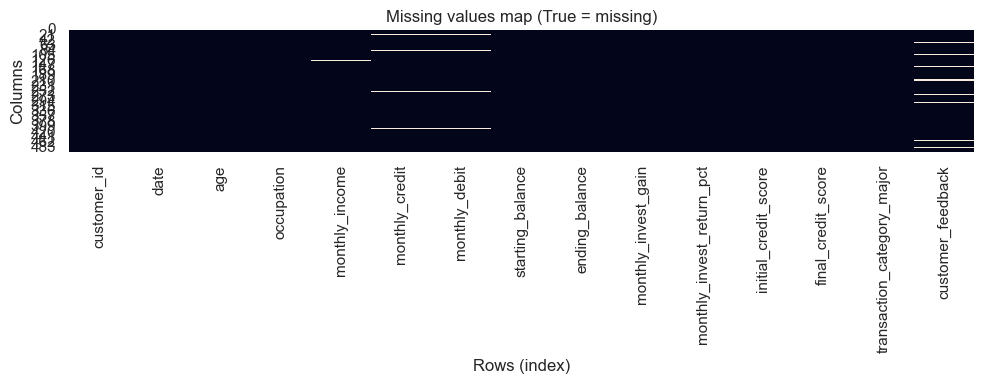

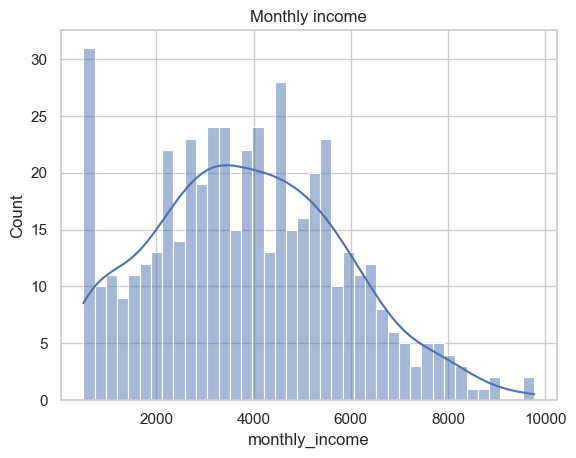

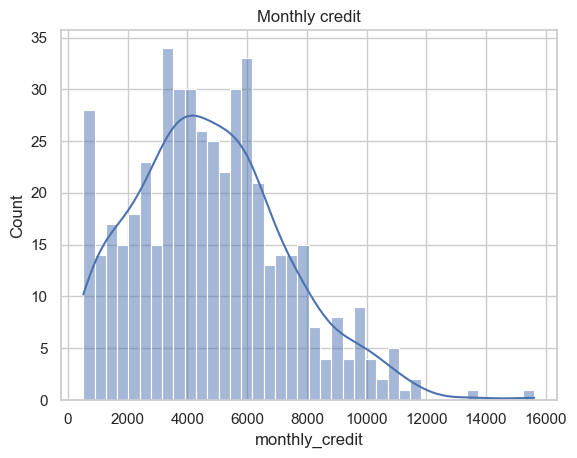

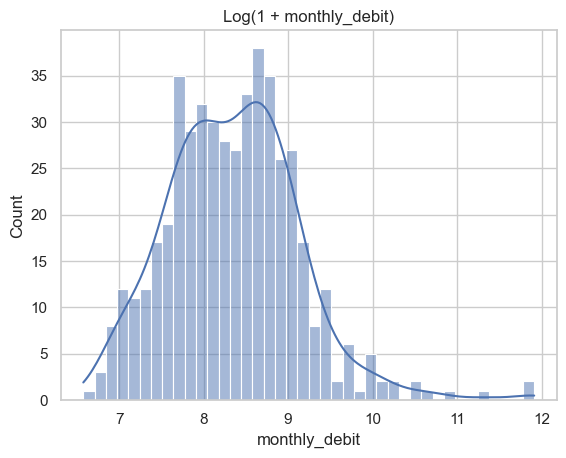

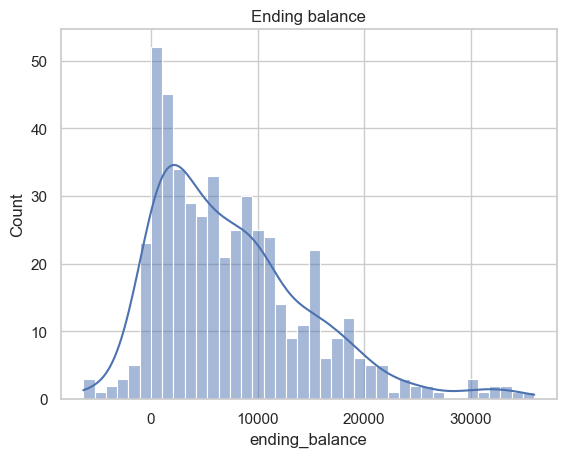

C:\Users\Jonas\AppData\Local\Temp\ipykernel_10444\2943935619.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


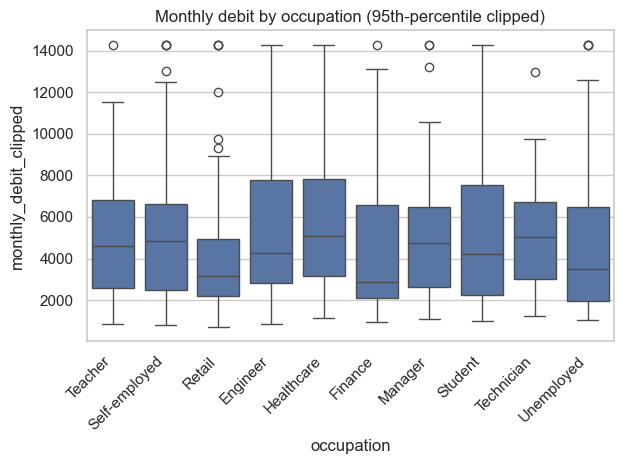

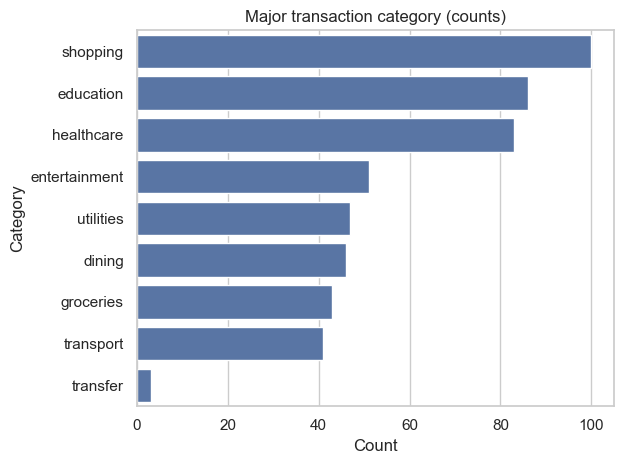

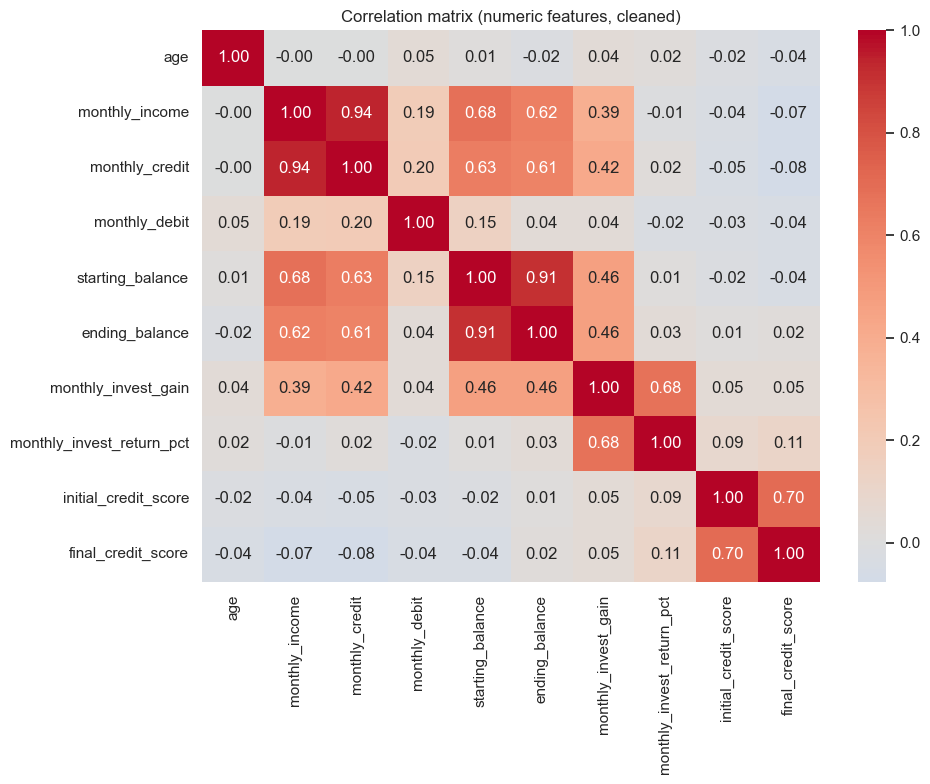


-- Sample (non-null) customer feedbacks (10) --
customer_id                                                  customer_feedback
  CUST00396            Debits slightly up. Keep an eye on healthcare spending.
  CUST00444   Great savings! Keep up excellent management of grocery expenses.
  CUST00010       Groceries were pricey; next month requires strict budgeting.
  CUST00078 Excellent cash flow. Consider ways to optimize your utility bills.
  CUST00375              High healthcare debits, but strong end balance. Good.
  CUST00034             Shopping was okay; steady progress on financial goals.
  CUST00083   Monitor dining expenses closely to prevent future balance drops.
  CUST00465   Excellent month! Consider adding more to your long-term savings.
  CUST00124       Good balance. Keep monitoring healthcare expenses carefully.
  CUST00095 Monitor shopping closely to maintain your current healthy balance.

✓ EDA complete — summary written to data/eda_summary.json


In [15]:
# EDA: load the saved CSV and perform quick exploratory analysis with visuals and summaries
pd.set_option('display.max_columns', None)

# Load dataset saved earlier (falls back to generated `df` if file missing)
try:
    df_eda = pd.read_csv(output_filename)
    print(f"Loaded dataset from {output_filename} — rows: {len(df_eda)}")
except Exception as e:
    print(f"Could not load {output_filename} ({e}), using in-memory `df` from simulation — rows: {len(df)}")
    df_eda = df.copy()

# Quick peek
print('\n-- Head (first 8 rows) --')
print(df_eda.head(8).to_string(index=False))

# Data types & missingness
print('\n-- Info & dtypes --')
print(df_eda.dtypes)

print('\n-- Missing values per column --')
print(df_eda.isnull().sum())

# Numeric summary
numeric_cols = [c for c in df_eda.columns if df_eda[c].dtype in ['int64','float64']]
print('\n-- Numeric summary (describe) --')
print(df_eda[numeric_cols].describe())

# Show value counts for categorical fields
cat_cols = ['occupation', 'transaction_category_major']
for c in cat_cols:
    if c in df_eda.columns:
        print(f"\nTop categories for {c}:")
        print(df_eda[c].value_counts(dropna=False).head(10))

# Visualizations (seaborn-only)
sns.set_theme(style='whitegrid')

# 1) Missingness map
ax = sns.heatmap(df_eda.isnull(), cbar=False)
ax.set_title('Missing values map (True = missing)')
ax.set_xlabel('Rows (index)')
ax.set_ylabel('Columns')
fig = ax.get_figure()
fig.set_size_inches(10,4)
fig.tight_layout()
plt.show()

# 2) Distributions (income, credit, debit, ending balance) — separate figures
sns.histplot(df_eda['monthly_income'].dropna(), bins=40, kde=True).set(title='Monthly income')
plt.show()

sns.histplot(df_eda['monthly_credit'].dropna(), bins=40, kde=True).set(title='Monthly credit')
plt.show()

sns.histplot(np.log1p(df_eda['monthly_debit'].dropna()), bins=40, kde=True).set(title='Log(1 + monthly_debit)')
plt.show()

sns.histplot(df_eda['ending_balance'].dropna(), bins=40, kde=True).set(title='Ending balance')
plt.show()

# 3) Boxplots by occupation for monthly_debit (clip extreme outliers for readability)
if 'occupation' in df_eda.columns:
    tmp = df_eda.copy()
    tmp['monthly_debit_clipped'] = tmp['monthly_debit'].clip(upper=tmp['monthly_debit'].quantile(0.95))
    ax = sns.boxplot(x='occupation', y='monthly_debit_clipped', data=tmp)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title('Monthly debit by occupation (95th-percentile clipped)')
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

# 4) Category counts
if 'transaction_category_major' in df_eda.columns:
    vc = df_eda['transaction_category_major'].value_counts(dropna=False)
    ax = sns.barplot(x=vc.values, y=vc.index)
    ax.set_title('Major transaction category (counts)')
    ax.set_xlabel('Count')
    ax.set_ylabel('Category')
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

# 5) Correlation heatmap of numeric fields (auto-filtered for clean plot)
# Remove columns with zero variance or >50% missing values
num_for_corr = [
    c for c in numeric_cols
    if df_eda[c].nunique(dropna=True) > 1 and df_eda[c].notnull().sum() > len(df_eda)*0.5
]
if num_for_corr:
    corr = df_eda[num_for_corr].corr()
    ax = sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    ax.set_title('Correlation matrix (numeric features, cleaned)')
    fig = ax.get_figure()
    fig.set_size_inches(10,8)
    fig.tight_layout()
    plt.show()
else:
    print('No suitable numeric columns for correlation matrix after filtering.')

# 6) Small textual analysis: sample customer feedbacks
print('\n-- Sample (non-null) customer feedbacks (10) --')
if 'customer_feedback' in df_eda.columns:
    nonnull_fb = df_eda[df_eda['customer_feedback'].notnull()][['customer_id','customer_feedback']]
    if len(nonnull_fb) == 0:
        print('No non-null feedbacks to show.')
    else:
        sample_fb = nonnull_fb.sample(n=min(10, len(nonnull_fb)), random_state=42)
        print(sample_fb.to_string(index=False))
else:
    print('No customer_feedback column found.')

# Save a small EDA summary file for quick reference
eda_summary = {
    'rows': len(df_eda),
    'columns': list(df_eda.columns),
    'missing_per_column': df_eda.isnull().sum().to_dict(),
    'numeric_summary': df_eda[numeric_cols].describe().to_dict()
}

with open('data/eda_summary.json','w', encoding='utf-8') as f:
    json.dump(eda_summary, f, indent=2)

print('\n✓ EDA complete — summary written to data/eda_summary.json')


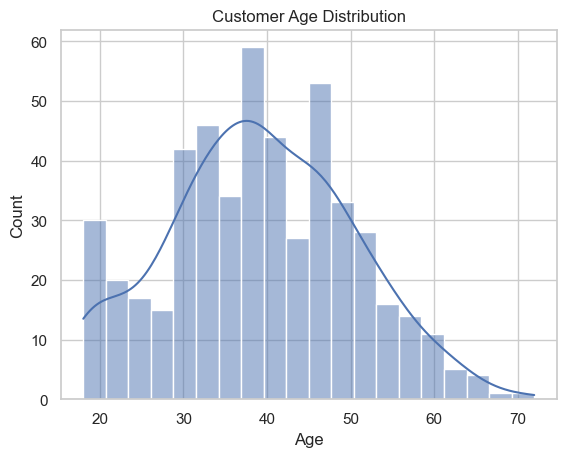

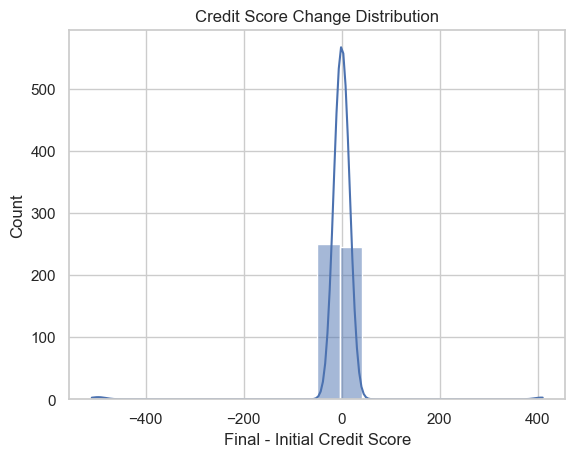

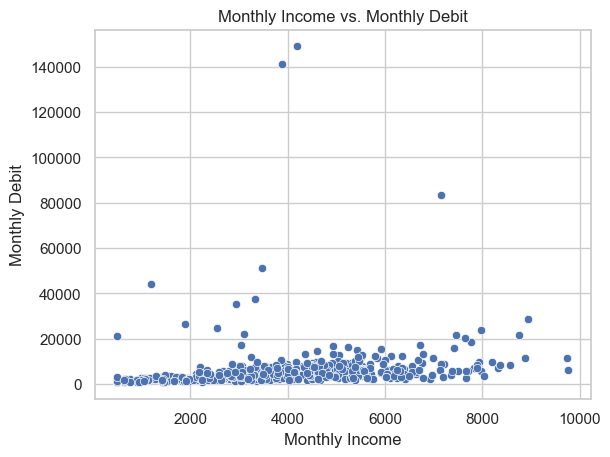

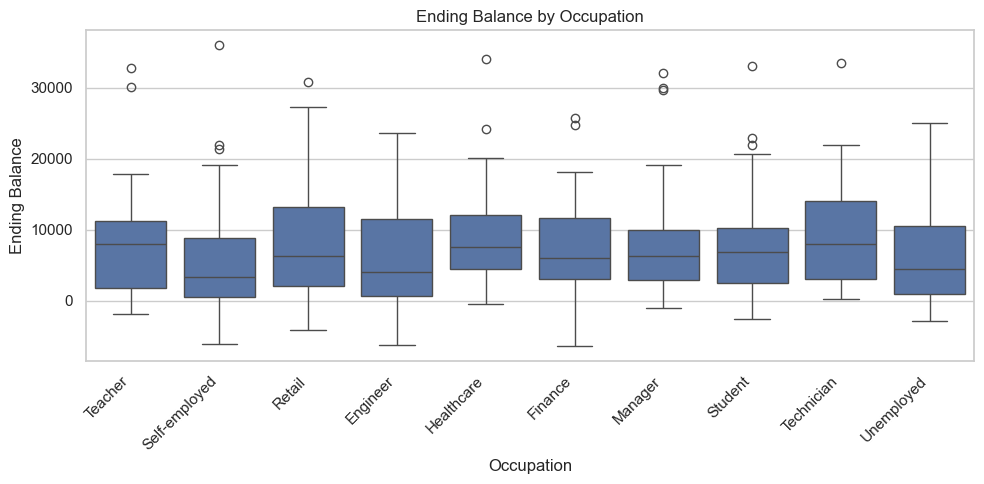

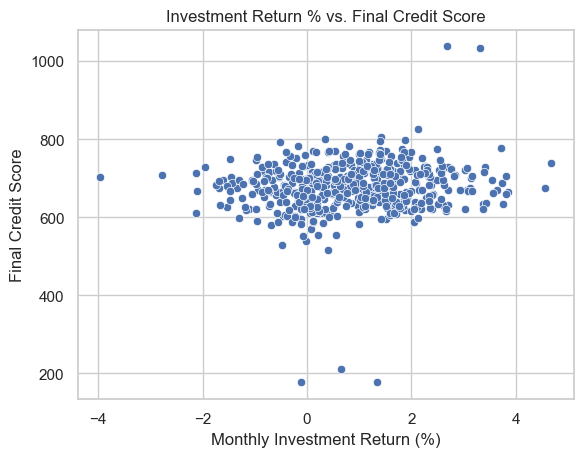

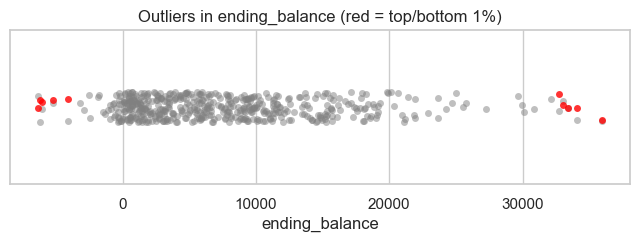

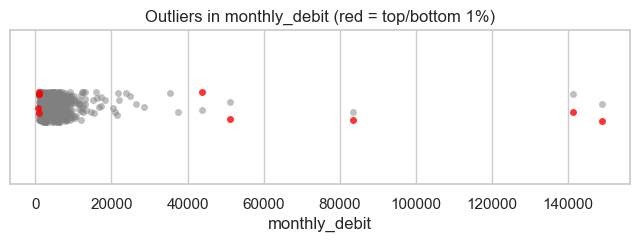

In [11]:
# Additional charts

# Age distribution
sns.histplot(df_eda['age'].dropna(), bins=20, kde=True)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Credit score change distribution
if 'final_credit_score' in df_eda.columns and 'initial_credit_score' in df_eda.columns:
    score_change = df_eda['final_credit_score'] - df_eda['initial_credit_score']
    sns.histplot(score_change.dropna(), bins=20, kde=True)
    plt.title('Credit Score Change Distribution')
    plt.xlabel('Final - Initial Credit Score')
    plt.ylabel('Count')
    plt.show()

# Scatter: monthly_income vs. monthly_debit
sns.scatterplot(x='monthly_income', y='monthly_debit', data=df_eda)
plt.title('Monthly Income vs. Monthly Debit')
plt.xlabel('Monthly Income')
plt.ylabel('Monthly Debit')
plt.show()

# Boxplot: ending_balance by occupation
if 'occupation' in df_eda.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='occupation', y='ending_balance', data=df_eda)
    plt.title('Ending Balance by Occupation')
    plt.xlabel('Occupation')
    plt.ylabel('Ending Balance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Scatter: monthly_invest_return_pct vs. final_credit_score
if 'monthly_invest_return_pct' in df_eda.columns and 'final_credit_score' in df_eda.columns:
    sns.scatterplot(x='monthly_invest_return_pct', y='final_credit_score', data=df_eda)
    plt.title('Investment Return % vs. Final Credit Score')
    plt.xlabel('Monthly Investment Return (%)')
    plt.ylabel('Final Credit Score')
    plt.show()

# Outlier highlighting for ending_balance and monthly_debit (top/bottom 1%)
def highlight_outliers(series, quantile=0.01):
    lower = series.quantile(quantile)
    upper = series.quantile(1-quantile)
    return (series < lower) | (series > upper)

for col in ['ending_balance', 'monthly_debit']:
    if col in df_eda.columns:
        outlier_mask = highlight_outliers(df_eda[col])
        plt.figure(figsize=(8,2))
        sns.stripplot(x=df_eda[col], color='gray', alpha=0.5)
        sns.stripplot(x=df_eda.loc[outlier_mask, col], color='red', alpha=0.8)
        plt.title(f'Outliers in {col} (red = top/bottom 1%)')
        plt.xlabel(col)
        plt.show()


## Part 2.2: AI-generated summaries


In [7]:
# This cell provides consolidated EDA helpers and an AI-assisted summarizer.

from pathlib import Path

OUT_DIR = Path('data')
OUT_DIR.mkdir(parents=True, exist_ok=True)

def summary_statistics(df: pd.DataFrame):
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    stats = {"rows": len(df), "numeric": {}, "categorical_top": {}}
    if numeric_cols:
        stats['numeric'] = df[numeric_cols].describe().to_dict()
    for c in cat_cols:
        stats['categorical_top'][c] = df[c].value_counts(dropna=False).head(10).to_dict()
    return stats


def detect_anomalies(df: pd.DataFrame, numeric_cols: list) -> pd.DataFrame:
    if not numeric_cols:
        return pd.DataFrame()
    num = df[numeric_cols].copy()
    mu = num.mean()
    sigma = num.std(ddof=0).replace(0, np.nan)
    z = (num - mu) / sigma
    z_abs = z.abs()
    z_mask = (z_abs > 3).any(axis=1)

    iqr_mask = pd.Series(False, index=df.index)
    for c in numeric_cols:
        col = df[c]
        if col.dropna().empty:
            continue
        q1 = col.quantile(0.25); q3 = col.quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr; high = q3 + 1.5 * iqr
        iqr_mask = iqr_mask | ((col < low) | (col > high))

    combined = z_mask | iqr_mask
    anomalies = df[combined].copy()
    if not anomalies.empty:
        anomalies['_max_abs_z'] = z_abs.loc[anomalies.index].max(axis=1)
    return anomalies


def generate_ai_summaries(stats, corr_matrix, anomalies, df):
    # Build a short prompt-like summary for Gemini to consume
    lines = [f"rows: {stats.get('rows')}"]
    numeric = stats.get('numeric', {})
    for col in ['monthly_income','monthly_credit','monthly_debit','ending_balance','monthly_invest_return_pct']:
        try:
            m = numeric[col]['mean']
            lines.append(f"mean_{col}: {m:.2f}")
        except Exception:
            pass

    corr_lines = []
    try:
        if corr_matrix is not None:
            pairs = []
            cols = corr_matrix.columns.tolist()
            for i,a in enumerate(cols):
                for j,b in enumerate(cols):
                    if i>=j: continue
                    v = corr_matrix.iloc[i,j]
                    if abs(v) >= 0.4:
                        pairs.append((a,b,float(v)))
            pairs = sorted(pairs, key=lambda x: -abs(x[2]))
            for a,b,v in pairs[:6]:
                corr_lines.append(f"{a} vs {b}: {v:.2f}")
    except Exception:
        pass

    prompt_body = "\n".join(lines + ["--- correlations ---"] + corr_lines + [f"anomalies_count: {len(anomalies)}"])

    # Primary path: use Google GenAI (Gemini) if SDK and API key are present
    if 'genai' in globals() and genai is not None and 'types' in globals() and types is not None and os.getenv('GOOGLE_API_KEY'):
        try:
            client = genai.Client(api_key=os.getenv('GOOGLE_API_KEY'))
            system = (
                "You are a data analyst. Based on the stats and correlations provided, produce up to 6 short plain-English insights. "
                "Return a JSON array of objects with keys 'topic' and 'insight'. Each insight should be 1-2 sentences."
            )
            contents = [system + "\n\n" + prompt_body]
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                contents=contents,
                config=types.GenerateContentConfig(system_instruction=system)
            )
            text = _extract_text(response)
            # Extract JSON substring if the model wraps the output
            start = text.find('[')
            end = text.rfind(']')
            if start != -1 and end != -1 and end > start:
                json_text = text[start:end+1]
                parsed = json.loads(json_text)
                out_lines = []
                for o in parsed[:6]:
                    topic = o.get('topic') or o.get('title') or 'insight'
                    insight = o.get('insight') or o.get('text') or o.get('feedback') or ''
                    out_lines.append(f"- {topic}: {insight}")
                return "\n".join(out_lines)
            # fallback: return raw text if JSON not found
            return text
        except Exception as e:
            print(f"GenAI call failed: {e} — falling back to heuristic summarizer")

    # Fallback heuristic (used only if GenAI not available)
    insights = []
    try:
        if 'monthly_income' in df.columns and 'monthly_invest_return_pct' in df.columns:
            c = df[['monthly_income','monthly_invest_return_pct']].dropna().corr().iloc[0,1]
            if math.isnan(c): c = 0.0
            if c>0.2:
                insights.append('Higher income weakly associates with higher investment return pct.')
            elif c<-0.2:
                insights.append('Higher income tends to have lower investment return pct in this sample.')
            else:
                insights.append('No strong relationship between income and investment return pct.')
    except Exception:
        pass

    try:
        if 'monthly_income' in df.columns and 'ending_balance' in df.columns:
            c = df[['monthly_income','ending_balance']].dropna().corr().iloc[0,1]
            if c>0.5:
                insights.append('Monthly income strongly correlates with ending balance.')
            elif c>0.2:
                insights.append('Monthly income moderately correlates with ending balance.')
            else:
                insights.append('Weak relationship between income and ending balance.')
    except Exception:
        pass

    try:
        if 'monthly_debit' in df.columns and 'ending_balance' in df.columns:
            c = df[['monthly_debit','ending_balance']].dropna().corr().iloc[0,1]
            if c<-0.5:
                insights.append('Higher debits strongly associate with lower ending balances.')
            elif c<-0.2:
                insights.append('Debits moderately negatively associate with ending balance.')
            else:
                insights.append('No strong negative relationship between debits and ending balance.')
    except Exception:
        pass

    try:
        if 'transaction_category_major' in df.columns:
            top = df['transaction_category_major'].value_counts().head(3).to_dict()
            top_str = ', '.join([f"{k}({v})" for k,v in top.items()])
            insights.append(f"Top categories: {top_str}.")
    except Exception:
        pass

    try:
        if len(anomalies)==0:
            insights.append('Very few extreme outliers detected across numeric fields.')
        else:
            s = anomalies.head(3)
            insights.append(f"Detected {len(anomalies)} anomalous rows. Sample IDs: {', '.join(map(str, s.get('customer_id', s.index).tolist()[:3]))}.")
    except Exception:
        pass

    try:
        if 'initial_credit_score' in df.columns and 'final_credit_score' in df.columns:
            changes = (df['final_credit_score'] - df['initial_credit_score']).dropna()
            if not changes.empty:
                mean_change = changes.mean()
                if mean_change>2:
                    insights.append('Credit scores increased slightly on average.')
                elif mean_change<-2:
                    insights.append('Credit scores decreased slightly on average.')
                else:
                    insights.append('Average credit score change is small.')
    except Exception:
        pass

    insights = insights[:6]
    return '\n'.join([f"- {s}" for s in insights])



In [8]:
# Run the consolidated EDA + AI summary on the dataframe `df_eda` if present (falls back to `df`)
try:
    working_df = df_eda
except NameError:
    working_df = globals().get('df', None)

if working_df is None:
    raise RuntimeError('Could not find a dataframe to run EDA on (no df_eda or df in notebook scope).')

stats = summary_statistics(working_df)
with open(OUT_DIR / 'eda_combined_stats.json', 'w', encoding='utf-8') as f:
    json.dump(stats, f, indent=2, default=lambda x: str(x))

numeric_cols = working_df.select_dtypes(include=['number']).columns.tolist()
# correlation
corr = None
if len(numeric_cols) >= 2:
    corr = working_df[numeric_cols].corr()
    # save a CSV of correlations for quick inspection
    corr.to_csv(OUT_DIR / 'correlations.csv')

# anomalies
anoms = detect_anomalies(working_df, numeric_cols)
anoms.to_csv(OUT_DIR / 'anomalies_combined.csv', index=False)

# AI or heuristic summary
ai_text = generate_ai_summaries(stats, corr, anoms, working_df)
with open(OUT_DIR / 'ai_summary.txt', 'w', encoding='utf-8') as f:
    f.write(ai_text)

print('\n=== AI / heuristic insights ===\n')
print(ai_text)
print(f"\nWrote combined EDA outputs to: {OUT_DIR.resolve()}")



=== AI / heuristic insights ===

- Income & Credit Activity: There's a very strong positive correlation (0.94) between monthly income and monthly credit. This indicates that higher income is closely tied to increased credit activity, suggesting income significantly influences credit usage or availability.
- Financial Balance Stability: The very strong positive correlation (0.91) between starting and ending balances highlights that initial financial health largely determines the final financial position. A strong starting balance is a key indicator of a healthy ending balance.
- Credit Score Persistence: An individual's initial credit score has a strong positive correlation (0.70) with their final credit score. This suggests that an established creditworthiness tends to be consistent over time.
- Income & Initial Financial Standing: Monthly income is strongly correlated (0.68) with the starting balance. This implies that higher earnings often contribute to a more robust financial posit

In [ ]:
# End of Part 2


## Part 3: Data-preprocessing

In [25]:
# Use Gemini for sentiment and topic classification
def generate_sentiment_topic_gemini_batch(feedbacks, n_requests=10, model="gemini-2.5-flash-lite", max_retries=3, retry_delay=5, batch_delay_seconds=4):
    """Send feedbacks to Gemini in batches and return sentiment and topic maps.

    feedbacks: list of dicts, each with 'customer_id' and 'feedback'.
    Returns: {customer_id: {'sentiment': str, 'topic': str}}
    """
    if 'genai' not in globals() or genai is None or 'types' not in globals() or types is None:
        raise RuntimeError("Google GenAI SDK not available.")

    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        raise ValueError("GOOGLE_API_KEY not found.")

    client = genai.Client(api_key=GOOGLE_API_KEY)

    result_map = {}
    total = len(feedbacks)
    if total == 0:
        return result_map

    batch_size = max(1, math.ceil(total / n_requests))

    for i in range(0, total, batch_size):
        batch = feedbacks[i:i+batch_size]
        items_text = []
        for f in batch:
            items_text.append(f"ID: {f['customer_id']} | Feedback: {f['feedback']}")
        prompt_body = "\n".join(items_text)
        prompt = (
            "You are given multiple customer feedbacks (one per line in the format 'ID: <id> | Feedback: <text>').\n"
            "For each feedback, classify the sentiment as 'positive', 'neutral', or 'negative', and detect the main topic as one of: 'savings', 'loan', 'investment', 'credit', or 'other'.\n"
            "Return a JSON array of objects with fields {\"customer_id\": <id>, \"sentiment\": <sentiment>, \"topic\": <topic>} and NOTHING ELSE.\n"
            "Respond with valid JSON only.\n\n"
            f"Feedbacks:\n{prompt_body}"
        )

        attempt = 0
        resp_text = None
        last_exception = None
        while attempt < max_retries:
            try:
                print(f"Sending Gemini batch request for feedbacks {i} to {i+len(batch)-1}...")
                response = client.models.generate_content(
                    model=model,
                    contents=[prompt],
                    config=types.GenerateContentConfig(system_instruction="Classify sentiment and topic for customer feedbacks.")
                )
                resp_text = _extract_text(response)
                if resp_text:
                    break
                else:
                    raise RuntimeError('Empty response from Gemini')
            except Exception as e:
                last_exception = e
                attempt += 1
                wait = retry_delay * (2 ** (attempt - 1))
                print(f"Gemini batch request failed (attempt {attempt}/{max_retries}): {e}. Retrying in {wait}s...")
                time.sleep(wait)

        if resp_text is None:
            raise RuntimeError(f"Gemini failed for batch starting at index {i} after {max_retries} attempts.") from last_exception

        if resp_text.startswith('```json') and resp_text.endswith('```'):
            resp_text = resp_text[7:-3].strip()
        elif resp_text.startswith('```') and resp_text.endswith('```'):
            resp_text = resp_text[3:-3].strip()
        try:
            parsed = json.loads(resp_text)
        except Exception:
            start = resp_text.find('[')
            end = resp_text.rfind(']')
            if start != -1 and end != -1:
                parsed = json.loads(resp_text[start:end+1])

        if not isinstance(parsed, list):
            raise ValueError(f"Invalid response for batch {i}.")

        for obj in parsed:
            cid = obj.get('customer_id')
            sent = obj.get('sentiment')
            top = obj.get('topic')
            if cid and sent and top:
                result_map[str(cid)] = {'sentiment': str(sent), 'topic': str(top)}

        time.sleep(batch_delay_seconds)

    return result_map

In [26]:
# Data Preprocessing using LLMs / SLMs

# Copy df_eda to df_preproc and drop ID columns
df_preproc = df_eda.copy()
df_preproc = df_preproc.drop(columns=['customer_id'])

# 1. Handle missing values
num_cols = df_preproc.select_dtypes(include=['number']).columns
cat_cols = df_preproc.select_dtypes(include=['object']).columns.tolist()

# Exclude text fields from categorical encoding
text_fields = ['customer_feedback']
cat_encode_cols = [col for col in cat_cols if col not in text_fields]

# Impute numerics with median
if len(num_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    df_preproc[num_cols] = num_imputer.fit_transform(df_preproc[num_cols])

# Impute categoricals with mode
if len(cat_encode_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_preproc[cat_encode_cols] = cat_imputer.fit_transform(df_preproc[cat_encode_cols])

# 2. Normalize numerical features
if len(num_cols) > 0:
    scaler = StandardScaler()
    df_preproc[num_cols] = scaler.fit_transform(df_preproc[num_cols])

# 3. Encode categorical variables (excluding text fields)
if len(cat_encode_cols) > 0:
    for col in cat_encode_cols:
        le = LabelEncoder()
        df_preproc[col] = le.fit_transform(df_preproc[col].astype(str))

# 4. Process text fields (customer_feedback)
# Impute missing feedback with 'No feedback provided'
if 'customer_feedback' in df_preproc.columns:
    df_preproc['customer_feedback'] = df_preproc['customer_feedback'].fillna('No feedback provided')

    # Prepare feedbacks for Gemini
    feedback_list = []
    for idx, row in df_preproc.iterrows():
        feedback_list.append({'customer_id': row.get('customer_id', idx), 'feedback': row['customer_feedback']})

    # Get sentiments and topics from Gemini
    st_map = generate_sentiment_topic_gemini_batch(feedback_list, n_requests=10, batch_delay_seconds=4)
    df_preproc['feedback_sentiment'] = df_preproc.apply(lambda row: st_map.get(str(row.get('customer_id', row.name)),{}).get('sentiment', 'neutral'), axis=1)
    df_preproc['feedback_topic'] = df_preproc.apply(lambda row: st_map.get(str(row.get('customer_id', row.name)), {}).get('topic', 'other'), axis=1)


print('Preprocessing complete. Sample:')
display(df_preproc.head())


Sending Gemini batch request for feedbacks 0 to 49...
Sending Gemini batch request for feedbacks 50 to 99...
Sending Gemini batch request for feedbacks 100 to 149...
Sending Gemini batch request for feedbacks 150 to 199...
Sending Gemini batch request for feedbacks 200 to 249...
Sending Gemini batch request for feedbacks 250 to 299...
Sending Gemini batch request for feedbacks 300 to 349...
Sending Gemini batch request for feedbacks 350 to 399...
Sending Gemini batch request for feedbacks 400 to 449...
Sending Gemini batch request for feedbacks 450 to 499...
Preprocessing complete. Sample:


,date,age,occupation,monthly_income,monthly_credit,monthly_debit,starting_balance,ending_balance,monthly_invest_gain,monthly_invest_return_pct,initial_credit_score,final_credit_score,transaction_category_major,customer_feedback,feedback_sentiment,feedback_topic
0,0.0,0.531674,0.939857,-0.072768,-0.376958,-0.343048,0.525168,0.675998,-0.304163,-0.268976,-0.239284,-0.077399,-1.511365,-1.152617,negative,other
1,0.0,-1.639164,0.939857,0.720964,0.591754,0.060636,0.682625,0.547825,1.155685,0.702920,-0.960144,-0.606704,0.140400,-0.119693,neutral,other
2,0.0,0.531674,0.210154,-0.196258,-0.262615,-0.059628,-0.698189,-0.769307,-0.414899,-0.053884,0.337403,0.119199,-1.511365,-1.173554,negative,other
3,0.0,0.983932,0.210154,0.038221,0.144418,0.022654,-0.120381,-0.248586,0.847304,1.077339,1.408395,1.132439,1.792165,1.471567,positive,other
4,0.0,-0.644196,-0.154697,0.940283,0.532908,-0.372229,0.371673,0.903423,1.031620,0.782584,0.522767,0.330921,-1.511365,-0.719906,negative,other


In [27]:
df_preproc

,date,age,occupation,monthly_income,monthly_credit,monthly_debit,starting_balance,ending_balance,monthly_invest_gain,monthly_invest_return_pct,initial_credit_score,final_credit_score,transaction_category_major,customer_feedback,feedback_sentiment,feedback_topic
0,0.0,0.531674,0.939857,-0.072768,-0.376958,-0.343048,0.525168,0.675998,-0.304163,-0.268976,-0.239284,-0.077399,-1.511365,-1.152617,negative,other
1,0.0,-1.639164,0.939857,0.720964,0.591754,0.060636,0.682625,0.547825,1.155685,0.702920,-0.960144,-0.606704,0.140400,-0.119693,neutral,other
2,0.0,0.531674,0.210154,-0.196258,-0.262615,-0.059628,-0.698189,-0.769307,-0.414899,-0.053884,0.337403,0.119199,-1.511365,-1.173554,negative,other
3,0.0,0.983932,0.210154,0.038221,0.144418,0.022654,-0.120381,-0.248586,0.847304,1.077339,1.408395,1.132439,1.792165,1.471567,positive,other
4,0.0,-0.644196,-0.154697,0.940283,0.532908,-0.372229,0.371673,0.903423,1.031620,0.782584,0.522767,0.330921,-1.511365,-0.719906,negative,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,-0.463293,1.669559,-0.863121,-0.964732,-0.061961,-0.208634,-0.585510,0.080622,0.591391,-0.012728,0.164568,0.140400,0.229267,positive,other
496,0.0,0.531674,1.304708,0.135032,-0.132754,-0.089434,0.979960,0.777436,0.984328,0.575458,1.161243,0.950963,-0.272541,-1.215429,negative,other
497,0.0,0.712578,0.939857,3.006173,2.161694,0.496265,3.749367,3.107409,2.054109,0.209006,-0.527628,-0.440351,-0.272541,-0.915323,negative,other
498,0.0,-1.367809,-1.614102,-0.191584,0.129719,-0.158263,0.205528,0.299280,-0.780767,-0.731026,-0.980740,-0.848672,-0.272541,-0.287195,neutral,other
